<img src="https://thevalley.es/wp-content/uploads/2016/11/thevalley-logo-negro.png" width="400"></img>

# Ejercicio sobre grafos - Medidas de centralidad y rutas

<img src="https://networkx.org/_static/networkx_logo.svg" width="200"></img>


En este ejemplo utilizaremos una parte de la red del metro de Madrid para hacer un primer acercamiento a las medidas de centralidad, identificación de comunidades y recorridos sobre el grafo.

<img src="https://www.redtransporte.com/img/transporte/madrid/metro-madrid/plano-metro-madrid.jpg" width="400"></img>

Documentación de la librería: https://networkx.github.io/

**Notebook por: David Rey**


In [ ]:
%matplotlib inline

import networkx as nx
from networkx import algorithms as nx_algos
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

# Carga de datos

Cargaremos una serie de datos de recorridos del metro de Madrid (**importante:** se trata solamente de 64 tramos, por tanto no está la red completa). En este caso los tramos se corresponderán con *aritas* del grafo, el modelo se construye a partir de los siguientes elementos:
* **STOP_1** es el nombre de la parada de partida en el tramo
* **STOP_2** es el nombre de la parada destino en el tramo
* **X_1** longitud de la ubicación de la parada de partida
* **Y_1** latitud de la ubicación de la parada de partida
* **X_2** longitud de la ubicación de la parada de destino
* **Y_2** latitud de la ubicación de la parada de destino
* **DIST** distancia en metros entre la parada de partida y la de destino
* **TIME** tiempo de viaje (en minutos) estimado del recorrido entre paradas. *importante:* este valor es un tiempo estimado para el trabajo en este ejercicio, no tiene por qué corresponderse con el tiempo real de desplazamiento entre estas paradas.

*Nota: No usaremos el atributo **LINE** en este ejercicio*

Fuente: [Datos abiertos Consorcio de Transportes de la Comunidad de Madrid](https://data-crtm.opendata.arcgis.com/)

In [ ]:
#
# Carga de los datos
#
url = 'https://github.com/davidreyblanco/ml-training/raw/master/data/metro-stops.csv'
metro_stop = pd.read_csv(url, delimiter=';')
metro_stop.head(5)

,STOP_1,STOP_2,LINE,X_1,Y_1,X_2,Y_2,DIST,TIME
0,Las Tablas,Chamartin,8,-3.66944,40.50833,-3.68259,40.47203,4182.231631,8.36
1,Chamartin,Plaza de Castilla,1,-3.68259,40.47203,-3.68917,40.46690,797.431666,1.59
2,Chamartin,Pinar de Chamartin,3,-3.68259,40.47203,-3.66680,40.48014,1613.637696,3.23
3,Las Tablas,Pinar de Chamartin,18,-3.66944,40.50833,-3.66680,40.48014,3138.324858,6.28
4,Plaza de Castilla,Colombia,4,-3.68917,40.46690,-3.67682,40.45634,1572.338147,3.14


In [ ]:
#
# Descripción básica de los atributos numéricos
#
metro_stop.describe()

,LINE,X_1,Y_1,X_2,Y_2,DIST,TIME
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,3.765625,-3.698910,40.433883,-3.693297,40.427802,1753.009813,3.505781
std,3.435308,0.022417,0.023761,0.030325,0.024688,1228.486629,2.457099
min,1.000000,-3.774620,40.384600,-3.812110,40.345240,306.395820,0.610000
25%,1.000000,-3.709865,40.421070,-3.704330,40.416880,907.902812,1.815000
50%,3.000000,-3.702180,40.430010,-3.695110,40.427720,1381.228241,2.765000
75%,5.000000,-3.676820,40.446370,-3.675718,40.438290,2335.272877,4.672500
max,18.000000,-3.663660,40.508330,-3.638320,40.480140,6568.595896,13.140000


# Creación del grafo desde un objeto pandas

Cargamos los datos desde un dataframe de pandas y mostraremos la red de metro usando las coordenadas (no proyectadas):*texto en cursiva*

Referencias:
* [Creación red networkx a partir de un dataframe pandas](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#networkx.convert_matrix.from_pandas_edgelist)
* [Visualización de redes con coordenadas geográficas](https://networkx.org/documentation/latest/auto_examples/drawing/plot_knuth_miles.html#sphx-glr-auto-examples-drawing-plot-knuth-miles-py)

## Importación del grafo

In [ ]:
G=nx.from_pandas_edgelist(metro_stop,
                          source = 'STOP_1',
                          target = 'STOP_2',
                          edge_attr=True)

## Dibujo del grafo usando las coordenadas geográficas

Solo como repaso, accedemos a los elementos que componen el grafo a través de las colecciones **nodes** y **edges**, vemos que los nodos no tienen ningún atributo

In [ ]:
G.nodes['Pinar de Chamartin']

{}

En cambio las aristas si tienen información del trayecto entre 'Las Tablas' y 'Chamartin'

In [ ]:
G.edges[('Las Tablas', 'Pinar de Chamartin')]
G.edges[('Las Tablas', 'Pinar de Chamartin')]['V'] = 999
G.edges[('Las Tablas', 'Pinar de Chamartin')]

{'LINE': 18,
 'X_1': -3.66944,
 'Y_1': 40.50833,
 'X_2': -3.6668,
 'Y_2': 40.48014,
 'DIST': 3138.3248579055585,
 'TIME': 6.28,
 'V': 999}

### Asignación de coordenadas

Hemos cargado las aristas, sin embargo de los nodos no tenemos sus coordenadas, para ello utilizaremos las localizaciones geográficas de las paradas de inicio y fin y construiremos una lista de coordenadas únicas por cada parada.

In [ ]:
#
# Construimos una lista única de paradas coordenadas, lo que hacemoses crear una lista de paradas no repetidas con sus coordenadas
#
metro_stop_nodes = pd.concat([metro_stop[['STOP_1','X_1','Y_1']].rename(columns={'STOP_1': 'STOP', 'X_1': 'X', 'Y_1': 'Y'}),
                              metro_stop[['STOP_2','X_2','Y_2']].rename(columns={'STOP_2': 'STOP', 'X_2': 'X', 'Y_2': 'Y'})
                              ]).drop_duplicates()
#
# Creamos una tupla que contenga las coordenadas
#
metro_stop_nodes['COORDS'] = metro_stop_nodes.apply(lambda x: (x['X'],x['Y']),axis=1)
# Eliminamos las coordenadas que no vamos a usar
del metro_stop_nodes['X']
del metro_stop_nodes['Y']



In [ ]:
#
# Creamos un atributo del grafo llamado position con un diccionario con las posiciones
#
G.position = {}

#
# Ponemos las coordenadas de cada nodo (aprovechamos para añadir las coordenadas como atributos)
#
for index, row in metro_stop_nodes.iterrows():
    G.position[row['STOP']] = row['COORDS']
    G.nodes[row['STOP']]['COORDS'] = row['COORDS']

No lo utilizaremos, pero vemos como hemos asignado al nodo un atributo con la tupla de sus coordenadas

In [ ]:
G.nodes['Las Tablas']

{'COORDS': (-3.66944, 40.50833)}

### Visualización del grafo con coordenadas geográficas

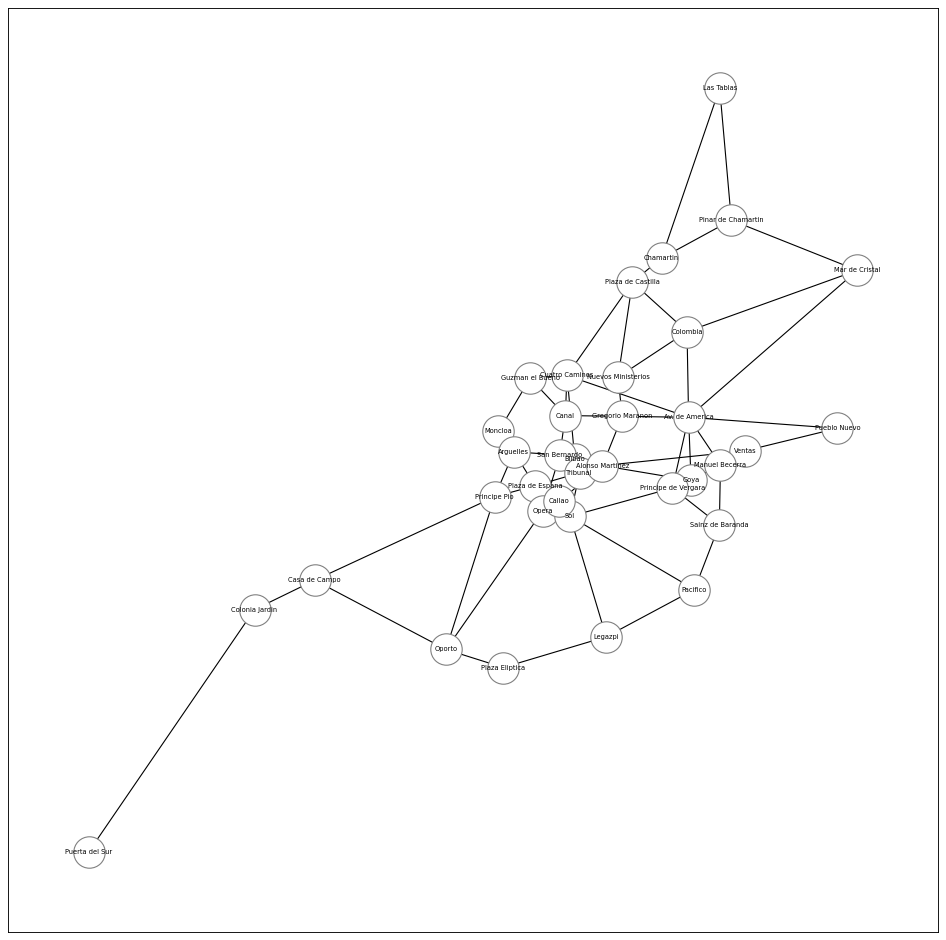

In [ ]:
from matplotlib.pyplot import figure

draw_options_small = {
    "font_size": 6,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "grey",
    "linewidths": 1,
    "width": 1
}

figure(figsize=(15, 15), dpi=80)

# Mostramos el grafo
nx.draw_networkx(G, pos=G.position,**draw_options_small)
# Establacemos los márgenes en los ejes para que los nodos no se corten
plt.show()

**pregunta** ¿qué tipo de grafo es?

* Dirigido / No dirigido
* Cíclico / Aciclico
* Es un grafo conexo o inconexo, si es el ultimo ¿de cuantos componentes?

# Cálculo de medidas de centralidad

Las medidas de centralidad de cada una de las estaciones nos indicarán su nivel de interconexión con otros elementos de la red. Por otro lado medidas como el **grado** nos inicarán el nivel de conexiones directas que tiene la red.

## Grado de las distintas estaciones

El grado es una medida que nos indica como está conectado un nodo de red con otros nodos de forma directa. En este ejemplo calcularemos el grafo de todos los elementos de la red y el grado medio de cada estación. En general cualquier parada de la red que no sea inicio ni fin tendrá un grado 2, cuando la parada tenga dos líneas y no sea final su grado será 4.

In [ ]:
#
# Grado de cada nodo
#
degree = G.degree()

degree_list = []

for (n,d) in degree:
    degree_list.append(d)

av_degree = sum(degree_list) / len(degree_list)
print('Grado medio del grafo: ', round(av_degree,2))

Grado medio del grafo:  3.56


**pregunta**: ¿Qué podemos decir de este valor?

### Descriptivo básico de una red: distribución de frecuencia del grado
Para verlo con mayor detalle mostraremos gráficamente en un histograma como se distribuye el nivel de conectividad directa de cada nodo (grado)

Text(0.5, 1.0, 'Metro de Madrid: Análisis del grado de los nodos')

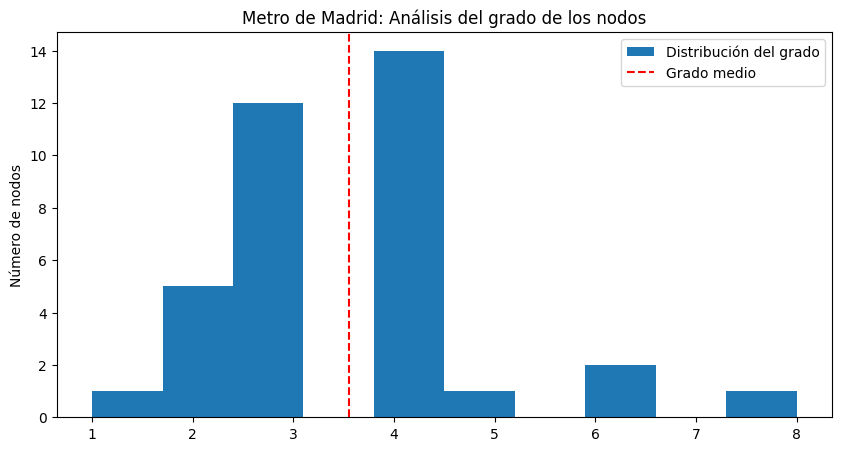

In [ ]:
#
# Generamos un histograma para ver la distribución de los grados
#
plt.rcParams["figure.figsize"] = (10,5)
plt.hist(degree_list,label='Distribución del grado')
plt.axvline(av_degree,color='r',linestyle='dashed',label='Grado medio')
plt.legend()
plt.ylabel('Número de nodos')
plt.title('Metro de Madrid: Análisis del grado de los nodos')


**pregunta** ¿Cuál es el nodo con mayor grado y el que menos? ¿cómo podríamos describir los nodos con mayor grado y menor?

In [ ]:
#
# Buscamos uno nodo que tenga el máximo grado
#
df_1 = pd.DataFrame.from_dict(dict(degree), orient='index')
df_1.columns = ['DEGREE']#
#
max_degree_stops = df_1[df_1.DEGREE == max(df_1['DEGREE'])]
print('Estación con mayor grado ', max(df_1['DEGREE']))
print(max_degree_stops)


Estación con mayor grado  8
                DEGREE
Av. de America       8


In [ ]:
#
# Y una de las que tienen menor grado
#
max_degree_stops = df_1[df_1.DEGREE == min(df_1['DEGREE'])]
print('Estación con menor grado ', min(df_1['DEGREE']))
print(max_degree_stops)

Estación con menor grado  1
                DEGREE
Puerta del Sur       1


In [ ]:
df_1

,DEGREE
Las Tablas,2
Chamartin,3
Plaza de Castilla,4
Pinar de Chamartin,3
Colombia,4
Mar de Cristal,3
Nuevos Ministerios,3
Cuatro Caminos,5
Av. de America,8
Gregorio Maranon,4


## Medida de cercanía (closeness)

La cercanía o *closeness* es la medida recíproca del camino más corto para un nodo u a todos sus n-1 nodos accesibles. Mayores valores de cercanía indican mayor centralidad (de nuevo una mayor conectividad del nodo con todos los nodos de la red).

In [ ]:
centrality_closeness = nx_algos.centrality.closeness_centrality(G)
df_2 = pd.DataFrame.from_dict(dict(centrality_closeness), orient='index')
df_2.columns = ['CLOSENESS']
#
# Mostramos los valores más altos de cercanía
#
df_2.sort_values(by='CLOSENESS', ascending=False).head(5)

,CLOSENESS
Av. de America,0.372340
Alonso Martinez,0.372340
Tribunal,0.368421
Bilbao,0.368421
Sol,0.364583


Y los menores (hemos de esperar que sean las paradas *más periféricas*)

In [ ]:
df_2.sort_values(by='CLOSENESS', ascending=True).head(5)

,CLOSENESS
Puerta del Sur,0.167464
Colonia Jardin,0.200000
Las Tablas,0.207101
Chamartin,0.236486
Pinar de Chamartin,0.236486


Para apreciarlo mejor mostramos la red gráficamente

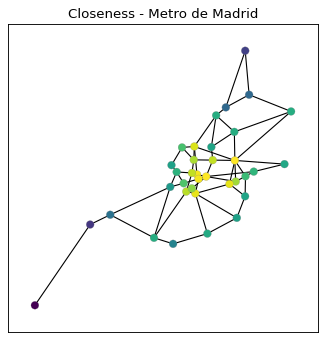

In [ ]:
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(5, 5), dpi=80)
# Mostramos el grafo
nx.draw_networkx(G,
                 pos=G.position,
                 with_labels=False,
                 node_color = df_2.CLOSENESS.values,
                 **draw_options_small)
# Establecer márgenes para los ejes para que los nodos no se corten
plt.title('Closeness - Metro de Madrid')
plt.show()

### Centralidad armónica

La centralidad armónica de un nodo u es la suma del recíproco de las medidas más cortas sobre el resto de nodos del grafo. En este caso usaremos la distancia como el *tiempo de viaje* expresado por el atributo *TIME* del nodo.

[Referencia](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.harmonic_centrality.html?highlight=harmonic#networkx.algorithms.centrality.harmonic_centrality)


In [ ]:
centrality_harmonic = nx_algos.centrality.harmonic_centrality(G, distance='TIME')
df_3 = pd.DataFrame.from_dict(dict(centrality_harmonic), orient='index')
df_3.columns = ['HARMONIC_CENTRALITY']
df_3.sort_values(by='HARMONIC_CENTRALITY', ascending=False).head(5)

,HARMONIC_CENTRALITY
Bilbao,9.899953
Tribunal,9.362615
San Bernardo,8.991531
Alonso Martinez,8.483513
Callao,7.453247


In [ ]:
df_3.sort_values(by='HARMONIC_CENTRALITY', ascending=True).head(5)

,HARMONIC_CENTRALITY
Puerta del Sur,1.214521
Las Tablas,1.967174
Colonia Jardin,2.398059
Mar de Cristal,2.484237
Casa de Campo,2.807295


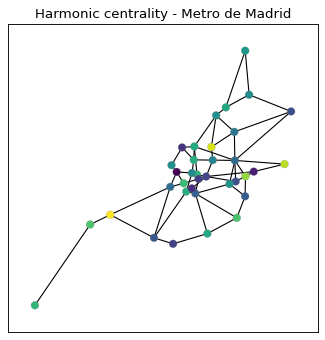

In [ ]:
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(5, 5), dpi=80)
# Mostramos el grafo
nx.draw_networkx(G,
                 pos=G.position,
                 with_labels=False,
                 node_color = df_3.HARMONIC_CENTRALITY.values,
                 **draw_options_small)
# Establecer márgenes para los ejes para que los nodos no se corten
plt.title('Harmonic centrality - Metro de Madrid')
plt.show()

**pregunta**: ¿Qué podemos decir entre la medida de cercanía y la de centralidad armónica?,¿cual podría representar los nodos más cercanos en tiempo de viaje?

### Medida de intermediación (betweeness)

La medida de centralidad betweenness para un nodo v es la suma de la fracción de todos los pares de nodos que pasan por v. Podríamos entenderlo como la importancia en del nodo v en la interconexión entre un conjunto de nodos (V).

[Referencia](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.centrality.betweenness_centrality.html?highlight=betweeness)



In [ ]:
centrality_betweeness = nx_algos.centrality.betweenness_centrality(G)
df_4 = pd.DataFrame.from_dict(dict(centrality_betweeness), orient='index')
df_4.columns = ['BETWEENESS']
df_4.sort_values(by='BETWEENESS', ascending=False).head(5)

,BETWEENESS
Av. de America,0.262596
Sol,0.188481
Cuatro Caminos,0.173849
Opera,0.156849
Principe de Vergara,0.136704


In [ ]:
df_4.sort_values(by='BETWEENESS', ascending=True).head(5)

,BETWEENESS
Las Tablas,0.000000
Puerta del Sur,0.000000
Pueblo Nuevo,0.006989
Nuevos Ministerios,0.012325
Plaza Eliptica,0.016823


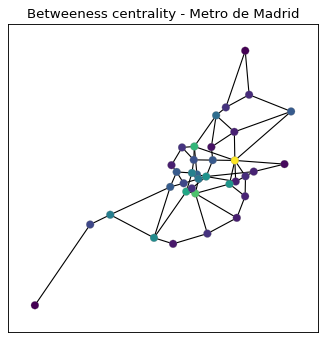

In [ ]:
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(5, 5), dpi=80)
# Mostramos el grafo
nx.draw_networkx(G,
                 pos=G.position,
                 with_labels=False,
                 node_color = df_4.BETWEENESS.values,
                 **draw_options_small)
plt.title('Betweeness centrality - Metro de Madrid')
plt.show()

**pregunta** ¿por qué la estación con mayor grado es la que logra una mayor puntación con esta mediad de centralidad?

### Resumen de medidas de centralidad

Recogemos las medidas de centralidad en una sola tabla (df_1 ... df_4)

In [ ]:
pd.concat([df_1, df_2, df_3, df_4], axis=1).sort_values(by='DEGREE', ascending=False)

,DEGREE,CLOSENESS,HARMONIC_CENTRALITY,BETWEENESS
Av. de America,8,0.372340,5.562698,0.262596
Sol,6,0.364583,7.422251,0.188481
Alonso Martinez,6,0.372340,8.483513,0.134391
Cuatro Caminos,5,0.360825,5.735370,0.173849
Canal,4,0.346535,6.692641,0.065537
Opera,4,0.350000,7.136602,0.156849
Principe Pio,4,0.277778,5.351987,0.075430
Principe de Vergara,4,0.364583,6.475449,0.136704
San Bernardo,4,0.353535,8.991531,0.114238
Arguelles,4,0.299145,6.920425,0.072963


## Densidad del grafo

La medida de densidad muestra la relación entre el número de aristas y nodos, en este caso al ser un grafo no dirigido. La densidad del grafo $G$ expresada como $d(G)$ se calcula como:

$$
d(G) = \frac{2m}{n(n - 1)}
$$

Donde $n$ es el número de nodos y $m$ es el número de aristas en el grafo $G$

[Referencia](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html?highlight=density#networkx.classes.function.density)

In [ ]:
density = nx.density(G)

print('La densidad de aristas (edge density) es: ' + str(density))

La densidad de aristas (edge density) es: 0.10158730158730159


# Identificación de comunidades

¿Cómo se organizan las paradas de metro en base a su conectividad?, recordamos su definición:

* Un nodo u está conectado a un nodo v si existe un camino que los una
* Un grafo está conectado si todos para cada nodo u existe un nodo v (u distinto de v) con el que esté conectado
* Un grafo está fuertemente conectado si y solamente si cualquier nodo del grafo está conectado con cualquier otro nodo del grafo

[Referencia](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.connectivity.average_node_connectivity.html?highlight=average_node_connectivity#networkx.algorithms.connectivity.connectivity.average_node_connectivity)


## Nivel de conectividad del grafo

Comenzamos calculando el nivel de conectividad de todo el grafo.

In [ ]:
nx_algos.connectivity.average_node_connectivity(G)

2.6126984126984127

**pregunta** viendo el grafo, ¿podemos decir que $G$ es un grafo **fuertemente conectado**?

## Detección de comunidades de paradas en la red de metro

Se dice que una red (o un subgrafo) tiene una estructura de comunidad, si los nodos de la red se pueden agrupar fácilmente en conjuntos de nodos con una alta densidad de conexión intragrupo.
De forma general se puede decir que es más probable que dos nodos estén conectados si pertenecen a las mismas comunidades, y por consiguiente aquellos nodos que no comparten comunidades será más improbable que estén conectados.

En nuestro caso calculamos las comunidades con el algoritmo más sencillo, el propuesto por [Clauset-Newman-Moore](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html?highlight=greedy_modularity_communities#networkx.algorithms.community.modularity_max.greedy_modularity_communities).**texto en negrita**

In [ ]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

#
# Detectamos las comunidades
#
communities = greedy_modularity_communities(G)
c = list(communities)

# Mostramos el número de comunidades detectadas
print(len(c))

5


In [ ]:
# Vemos cada uno de los clusters
community_0 = sorted(c[0])
community_1 = sorted(c[1])
community_2 = sorted(c[2])
community_3 = sorted(c[3])
community_4 = sorted(c[4])

print(community_0)
print(community_1)
print(community_2)
print(community_3)
print(community_4)

['Av. de America', 'Canal', 'Colombia', 'Cuatro Caminos', 'Gregorio Maranon', 'Guzman el Bueno', 'Mar de Cristal', 'Moncloa', 'Nuevos Ministerios', 'Plaza de Castilla']
['Callao', 'Legazpi', 'Opera', 'Oporto', 'Pacifico', 'Plaza Eliptica', 'Principe de Vergara', 'Sainz de Baranda', 'Sol']
['Alonso Martinez', 'Bilbao', 'Goya', 'Manuel Becerra', 'Pueblo Nuevo', 'San Bernardo', 'Tribunal', 'Ventas']
['Arguelles', 'Casa de Campo', 'Colonia Jardin', 'Plaza de Espana', 'Principe Pio', 'Puerta del Sur']
['Chamartin', 'Las Tablas', 'Pinar de Chamartin']


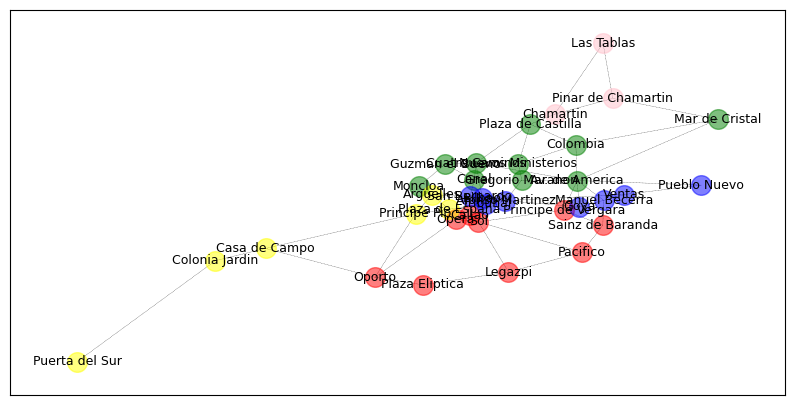

In [ ]:
#
# Dibujamos cada comunidad con un color distinto
#
nx.draw_networkx_nodes(G,G.position, nodelist=community_0, node_color='green', alpha=0.5, node_size=200)
nx.draw_networkx_nodes(G,G.position, nodelist=community_1, node_color='red', alpha=0.5, node_size=200)
nx.draw_networkx_nodes(G,G.position, nodelist=community_2, node_color='blue', alpha=0.5, node_size=200)
nx.draw_networkx_nodes(G,G.position, nodelist=community_3, node_color='yellow', alpha=0.5, node_size=200)
nx.draw_networkx_nodes(G,G.position, nodelist=community_4, node_color='pink', alpha=0.5, node_size=200)


nx.draw_networkx_edges(G,G.position,  style='dashed', width = 0.2)

nx.draw_networkx_labels(G, G.position, font_size=9)

plt.rcParams["figure.figsize"] = (20,15)
plt.show()

## Conectividad de las comunidades

Habíamos calculado la conectividad general del grafo, ¿pero qué podemos esperar de la conectividad de las comunidades?

In [ ]:
print('Connectivity del grafo G ', nx_algos.connectivity.average_node_connectivity(G))
for i in range(0, len(c)):
  x = G.subgraph(nodes = list(c[i]))
  connectivity = nx_algos.connectivity.average_node_connectivity(x)
  print('Connectivity comunidad [', i,']', connectivity)

Connectivity del grafo G  2.6126984126984127
Connectivity comunidad [ 0 ] 2.1777777777777776
Connectivity comunidad [ 1 ] 2.0833333333333335
Connectivity comunidad [ 2 ] 1.3214285714285714
Connectivity comunidad [ 3 ] 1.2
Connectivity comunidad [ 4 ] 2.0


## Puentes

Un puente en un grafo es una arista cuya eliminación causa un impacto en la conectividad de la red (el número de nodos conectados). Lógicamente un puente será una arista que no pertenezca a un ciclo.



**pregunta** viendo la forma de la red ¿qué tramos serán puentes en el grafo?

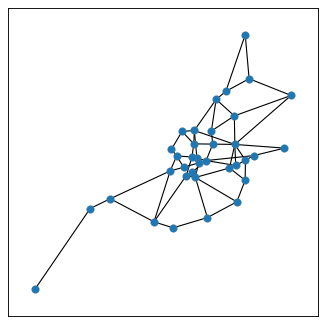

In [ ]:
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(5, 5), dpi=80)
# Mostramos el grafo
nx.draw_networkx(G,
                 pos=G.position,
                 with_labels=False,
                 **draw_options_small)
plt.show()

In [ ]:
#
# Confirmamos o no nuestras sospechas
#
list(nx_algos.bridges(G))
bridges = nx_algos.bridges(G)

In [ ]:
edge_color = list()
for edge in G.edges(data=True):
    color = 'r'
    if edge in bridges:
        color = 'g'
    edge_color.append(color)


Marcamos los puentes en **rojo**

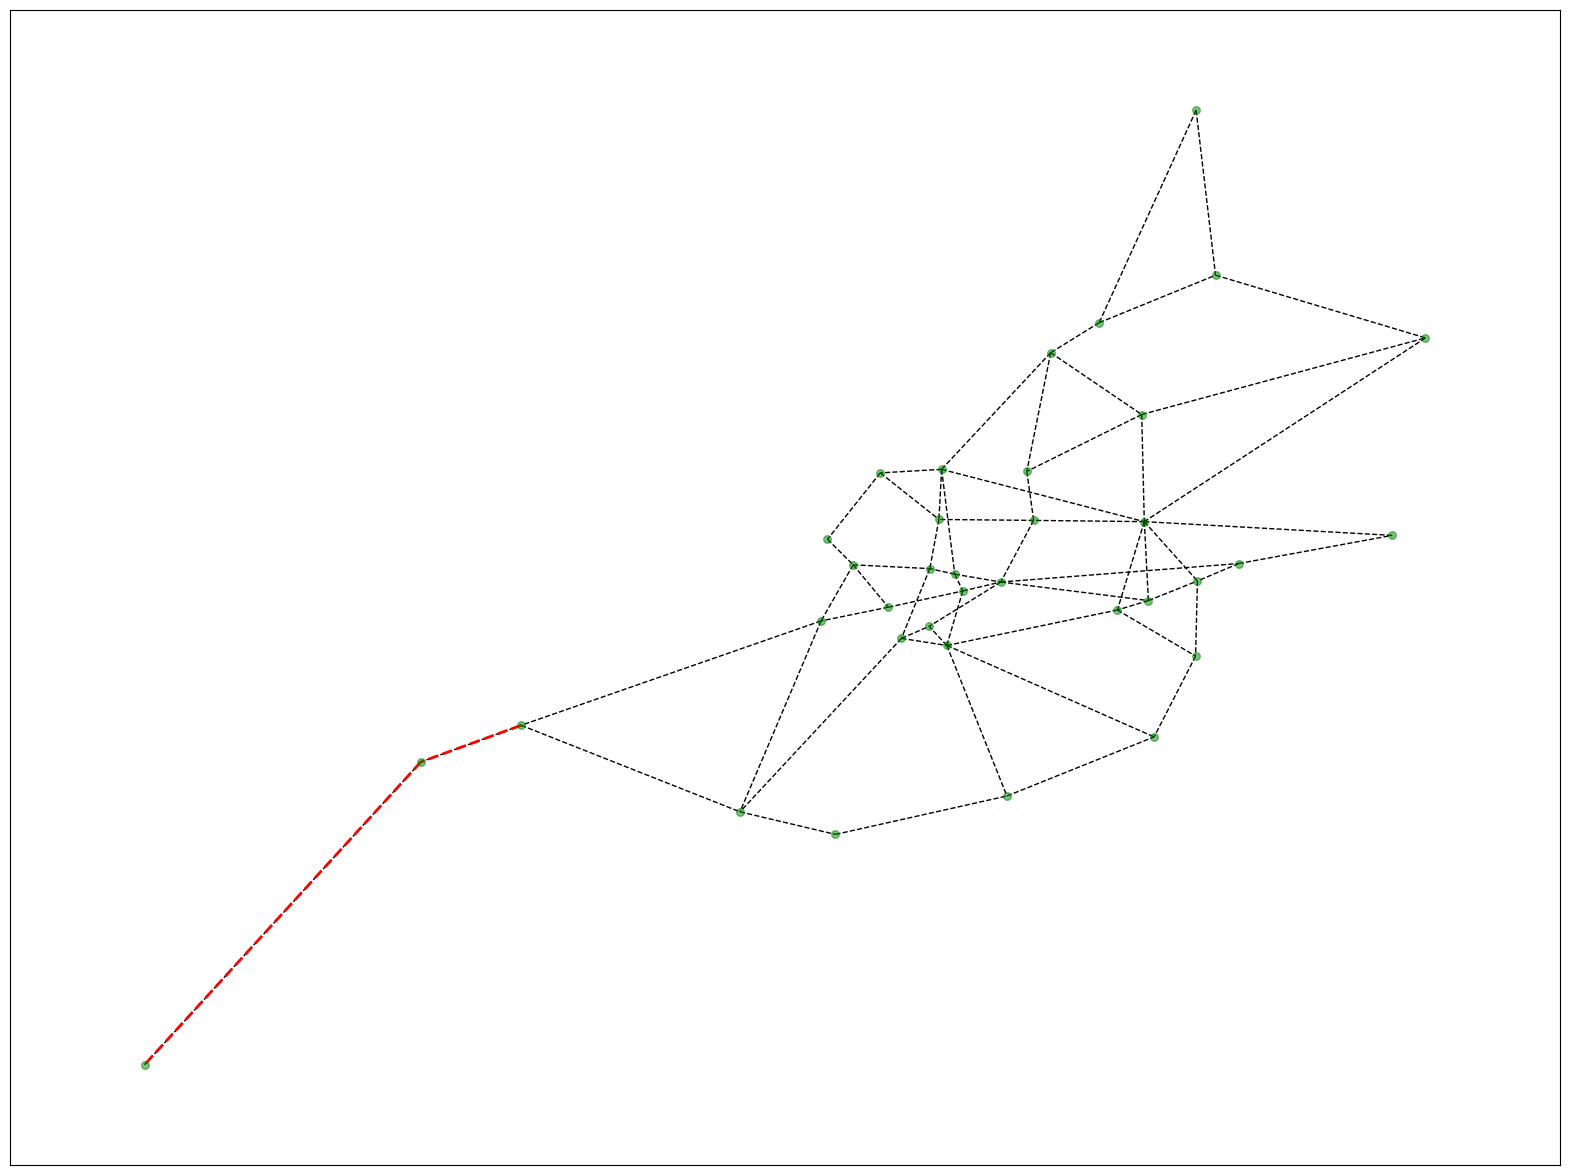

In [ ]:
# Mostramos el grafo señalando los puentes
nx.draw_networkx_nodes(G,G.position, nodelist=list(G.nodes), node_color='green', alpha=0.5, node_size=30)
#nx.draw_networkx_nodes(G,G.position, nodelist = list(G.nodes), node_color='white')
nx.draw_networkx_edges(G,G.position, style='dashed',width = 1)
nx.draw_networkx_edges(G,G.position, edgelist = list(nx_algos.bridges(G)), edge_color='r', style='dashed',width = 2)

plt.rcParams["figure.figsize"] = (7,7)
plt.show()
# Establecer márgenes para los ejes para que los nodos no se corten

**pregunta** ¿hemos confirmado nuestras sospechas?

## Recorridos del grafo

[Funciones de recorrido del grafo](https://networkx.org/documentation/stable/reference/algorithms/traversal.html)

### Recorrido en profundidad

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Depth-first-tree.svg/375px-Depth-first-tree.svg.png" width="200"></img>


Vamos calcular los trayectos a 3 paradas de la estación de Sol

In [ ]:
depth_limit=3
e = nx_algos.traversal.depth_first_search.dfs_edges(G, source='Sol', depth_limit=depth_limit)
list(e)

[('Sol', 'Tribunal'),
 ('Tribunal', 'Plaza de Espana'),
 ('Plaza de Espana', 'Arguelles'),
 ('Plaza de Espana', 'Principe Pio'),
 ('Tribunal', 'Bilbao'),
 ('Bilbao', 'Cuatro Caminos'),
 ('Bilbao', 'San Bernardo'),
 ('Bilbao', 'Alonso Martinez'),
 ('Sol', 'Callao'),
 ('Callao', 'Opera'),
 ('Opera', 'Oporto'),
 ('Sol', 'Legazpi'),
 ('Legazpi', 'Plaza Eliptica'),
 ('Legazpi', 'Pacifico'),
 ('Pacifico', 'Sainz de Baranda'),
 ('Sol', 'Principe de Vergara'),
 ('Principe de Vergara', 'Av. de America'),
 ('Av. de America', 'Gregorio Maranon'),
 ('Av. de America', 'Goya'),
 ('Av. de America', 'Manuel Becerra'),
 ('Av. de America', 'Pueblo Nuevo'),
 ('Av. de America', 'Colombia'),
 ('Av. de America', 'Mar de Cristal')]

In [ ]:
#
# El método tree nos devuelve los nodos del recorrido
#
n = nx_algos.traversal.depth_first_search.dfs_tree(G, source='Sol', depth_limit=depth_limit)
list(n)

['Sol',
 'Tribunal',
 'Plaza de Espana',
 'Arguelles',
 'Principe Pio',
 'Bilbao',
 'Cuatro Caminos',
 'San Bernardo',
 'Alonso Martinez',
 'Callao',
 'Opera',
 'Oporto',
 'Legazpi',
 'Plaza Eliptica',
 'Pacifico',
 'Sainz de Baranda',
 'Principe de Vergara',
 'Av. de America',
 'Gregorio Maranon',
 'Goya',
 'Manuel Becerra',
 'Pueblo Nuevo',
 'Colombia',
 'Mar de Cristal']

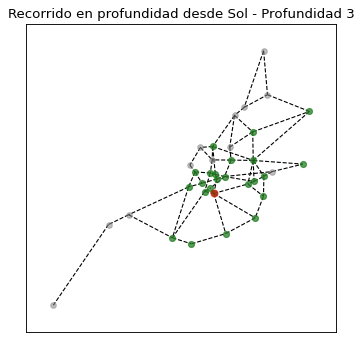

In [ ]:
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(5, 5), dpi=80)
#
# Mostramos el grafo Sol en color rojo
#  en verde todas las paradas a un alcance 2
#
nx.draw_networkx_nodes(G,G.position, node_color='grey', alpha=0.5, node_size=25)
nx.draw_networkx_nodes(G,G.position, nodelist=n, node_color='green', alpha=0.5, node_size=30)
nx.draw_networkx_nodes(G,G.position, nodelist=['Sol'], node_color='red', alpha=0.5, node_size=40)
nx.draw_networkx_edges(G,G.position, style='dashed',width = 1)
plt.title('Recorrido en profundidad desde Sol - Profundidad ' + str(depth_limit))
plt.show()

### Recorrido en anchura


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Breadth-first-tree.svg/375px-Breadth-first-tree.svg.png" width="200"></img>

Replicamos el proceso anterior esta vez usando el recorrido anchura desde la estación de **Sol**.

[Referencia](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.bfs_edges.html#networkx.algorithms.traversal.breadth_first_search.bfs_edges)

In [ ]:
depth_limit=3
e = nx_algos.traversal.breadth_first_search.bfs_edges(G, source='Sol', depth_limit=depth_limit)
list(e)

[('Sol', 'Tribunal'),
 ('Sol', 'Callao'),
 ('Sol', 'Opera'),
 ('Sol', 'Legazpi'),
 ('Sol', 'Pacifico'),
 ('Sol', 'Principe de Vergara'),
 ('Tribunal', 'Plaza de Espana'),
 ('Tribunal', 'Bilbao'),
 ('Tribunal', 'Alonso Martinez'),
 ('Opera', 'San Bernardo'),
 ('Opera', 'Oporto'),
 ('Legazpi', 'Plaza Eliptica'),
 ('Pacifico', 'Sainz de Baranda'),
 ('Principe de Vergara', 'Av. de America'),
 ('Principe de Vergara', 'Goya'),
 ('Plaza de Espana', 'Arguelles'),
 ('Plaza de Espana', 'Principe Pio'),
 ('Bilbao', 'Cuatro Caminos'),
 ('Alonso Martinez', 'Gregorio Maranon'),
 ('Alonso Martinez', 'Ventas'),
 ('San Bernardo', 'Canal'),
 ('Oporto', 'Casa de Campo'),
 ('Sainz de Baranda', 'Manuel Becerra'),
 ('Av. de America', 'Pueblo Nuevo'),
 ('Av. de America', 'Colombia'),
 ('Av. de America', 'Mar de Cristal')]

In [ ]:
#
# El método tree nos devuelve los nodos del recorrido
#
n = nx_algos.traversal.breadth_first_search.bfs_tree(G, source='Sol', depth_limit=depth_limit)
list(n)

['Sol',
 'Tribunal',
 'Callao',
 'Opera',
 'Legazpi',
 'Pacifico',
 'Principe de Vergara',
 'Plaza de Espana',
 'Bilbao',
 'Alonso Martinez',
 'San Bernardo',
 'Oporto',
 'Plaza Eliptica',
 'Sainz de Baranda',
 'Av. de America',
 'Goya',
 'Arguelles',
 'Principe Pio',
 'Cuatro Caminos',
 'Gregorio Maranon',
 'Ventas',
 'Canal',
 'Casa de Campo',
 'Manuel Becerra',
 'Pueblo Nuevo',
 'Colombia',
 'Mar de Cristal']

Mostramos el resultado del recorrido

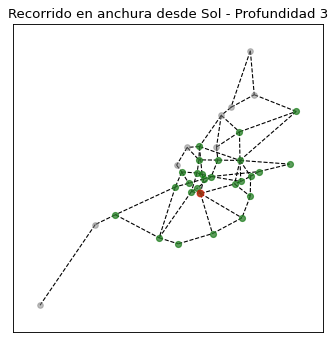

In [ ]:
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(5, 5), dpi=80)
#
# Mostramos el grafo Sol en color rojo
#  en verde todas las paradas a un alcance 2
#
nx.draw_networkx_nodes(G,G.position, node_color='grey', alpha=0.5, node_size=25)
nx.draw_networkx_nodes(G,G.position, nodelist=n, node_color='green', alpha=0.5, node_size=30)
nx.draw_networkx_nodes(G,G.position, nodelist=['Sol'], node_color='red', alpha=0.5, node_size=40)
nx.draw_networkx_edges(G,G.position, style='dashed',width = 1)
plt.title('Recorrido en anchura desde Sol - Profundidad ' + str(depth_limit))
plt.show()

**pregunta** ¿los resultados son iguales?

## Caminos entre dos nodos


### Caminos simples

Acabamos de llegar en autobús al intercambiador de Moncloa, ¿cómo podría llegar a Legazpi?


In [ ]:
possible_paths = nx_algos.simple_paths.all_simple_paths(G, source='Moncloa', target='Legazpi')
l_possible_paths = list(possible_paths)
print('Encontradas ', len(l_possible_paths), ' rutas distintas')

Encontradas  1113358  rutas distintas


Parece que son unas cuantas, y es aquí donde aparece la complejidad de los problemas que trabajan con redes, y en las que la **fuerza bruta** no es la mejor de las opciones.

Así que en este caso limitamos los caminos con una longitud mayor a 5 parada (podríamos quitar esta condición para ver cómo cambia el número de opciones)

In [ ]:
possible_paths = nx_algos.simple_paths.all_simple_paths(G, source='Moncloa', target='Legazpi',  cutoff=5)
l_possible_paths = list(possible_paths)
print('Encontradas ', len(l_possible_paths), ' rutas distintas')
l_possible_paths[0]

Encontradas  3  rutas distintas


['Moncloa', 'Arguelles', 'San Bernardo', 'Opera', 'Sol', 'Legazpi']

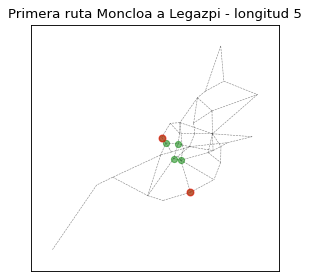

In [ ]:
#
# Dibujamos nuestra primera ruta
#
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(4, 4), dpi=80)
nx.draw_networkx_nodes(G,G.position, node_color='grey', alpha=0.5, node_size=0)
nx.draw_networkx_nodes(G,G.position, nodelist=l_possible_paths[0], node_color='green', alpha=0.5, node_size=30)
nx.draw_networkx_nodes(G,G.position, nodelist=['Moncloa','Legazpi'], node_color='red', alpha=0.5, node_size=40)
nx.draw_networkx_edges(G,G.position, style='dashed',width = 0.5, alpha=0.5)
plt.title('Primera ruta Moncloa a Legazpi - longitud ' + str(len(l_possible_paths[0]) - 1))
plt.show()

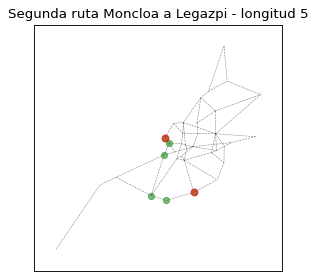

In [ ]:
#
# Dibujamos segunda primera ruta al azar
#
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(4, 4), dpi=80)
nx.draw_networkx_nodes(G,G.position, node_color='grey', alpha=0.5, node_size=0)
nx.draw_networkx_nodes(G,G.position, nodelist=l_possible_paths[2], node_color='green', alpha=0.5, node_size=30)
nx.draw_networkx_nodes(G,G.position, nodelist=['Moncloa','Legazpi'], node_color='red', alpha=0.5, node_size=40)
nx.draw_networkx_edges(G,G.position, style='dashed',width = 0.5, alpha=0.5)
plt.title('Segunda ruta Moncloa a Legazpi - longitud ' + str(len(l_possible_paths[2]) - 1))
plt.show()

## El camino más corto



Pero lo que más nos interesa es no perder el tiempo ver cual es la mejor opción para desplazarnos, para eso recurriremos a alguno de los algoritmos que tiene networkx. En particular usaremos el [algoritmo de dijkstra](https://es.wikipedia.org/wiki/Algoritmo_de_Dijkstra).

[Referencia](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path)

*shortest_path(G, source=None, target=None, weight=None, method='dijkstra')*

En nuestra primera aproximación usaremos la distancia no ponderada

In [ ]:
shortest_path = nx_algos.shortest_paths.generic.shortest_path(G, source='Moncloa', target='Legazpi', method='dijkstra')

Y ahora con la distancia ponderada

In [ ]:
shortest_path

['Moncloa', 'Arguelles', 'San Bernardo', 'Opera', 'Sol', 'Legazpi']

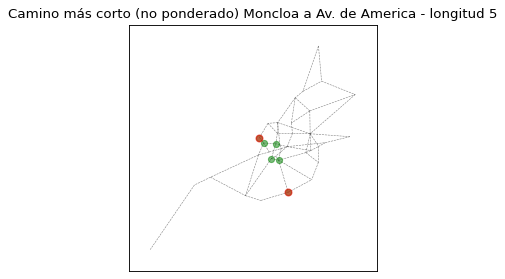

In [ ]:
#
# Mostramos la ruta más corta
#
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(4, 4), dpi=80)
nx.draw_networkx_nodes(G,G.position, node_color='grey', alpha=0.5, node_size=0)
nx.draw_networkx_nodes(G,G.position, nodelist=shortest_path, node_color='green', alpha=0.5, node_size=30)
nx.draw_networkx_nodes(G,G.position, nodelist=['Moncloa','Legazpi'], node_color='red', alpha=0.5, node_size=40)
nx.draw_networkx_edges(G,G.position, style='dashed',width = 0.5, alpha=0.5)
plt.title('Camino más corto (no ponderado) Moncloa a Av. de America - longitud ' + str(len(shortest_path) - 1))
plt.show()

Pero lo que más nos interesa aparte de pasar por el mínimo número de estaciones es tardar lo mínimo, por lo que usaremos como *medida de coste* el tiempo de viaje **TIME**

In [ ]:
#
# El proceso es similar
#
shortest_path = nx_algos.shortest_paths.generic.shortest_path(G, source='Moncloa',
                                                              target='Legazpi',
                                                              method='dijkstra',
                                                              weight='TIME')

In [ ]:
shortest_path

['Moncloa',
 'Arguelles',
 'San Bernardo',
 'Bilbao',
 'Tribunal',
 'Sol',
 'Legazpi']

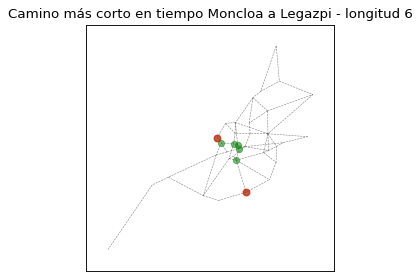

In [ ]:
#
# Mostramos la ruta más corta
#
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(4, 4), dpi=80)
nx.draw_networkx_nodes(G,G.position, node_color='grey', alpha=0.5, node_size=0)
nx.draw_networkx_nodes(G,G.position, nodelist=shortest_path, node_color='green', alpha=0.5, node_size=30)
nx.draw_networkx_nodes(G,G.position, nodelist=['Moncloa','Legazpi'], node_color='red', alpha=0.5, node_size=40)
nx.draw_networkx_edges(G,G.position, style='dashed',width = 0.5, alpha=0.5)
plt.title('Camino más corto en tiempo Moncloa a Legazpi - longitud ' + str(len(shortest_path) - 1))
plt.show()

# Ejercicio sobre rutas

¿Como podemos llegar lo más rápido posible desde Chamartín a puerta del Sur haciendo transbordo en Cuatro Caminos?, mostramos un gráfico finalmente con la ruta

Calculamos el primer tramo

In [ ]:
start_stop = 'Chamartin'
commuting_stop = 'Cuatro Caminos'
end_stop = 'Puerta del Sur'
path_part_1 = nx_algos.shortest_paths.generic.shortest_path(G, source=start_stop,
                                                              target=commuting_stop,
                                                              method='dijkstra',
                                                              weight='TIME')

Calculamos el segundo tramo

In [ ]:
path_part_2 =  nx_algos.shortest_paths.generic.shortest_path(G, source=commuting_stop,
                                                              target=end_stop,
                                                              method='dijkstra',
                                                              weight='TIME')

In [ ]:
path_part_1

['Chamartin', 'Plaza de Castilla', 'Cuatro Caminos']

In [ ]:
path_part_2

['Cuatro Caminos',
 'Guzman el Bueno',
 'Moncloa',
 'Arguelles',
 'Principe Pio',
 'Casa de Campo',
 'Colonia Jardin',
 'Puerta del Sur']

Unimos los tramos

In [ ]:
path_complete = path_part_1 + path_part_2[1:]
path_complete

['Chamartin',
 'Plaza de Castilla',
 'Cuatro Caminos',
 'Guzman el Bueno',
 'Moncloa',
 'Arguelles',
 'Principe Pio',
 'Casa de Campo',
 'Colonia Jardin',
 'Puerta del Sur']

Mostramos el resultado

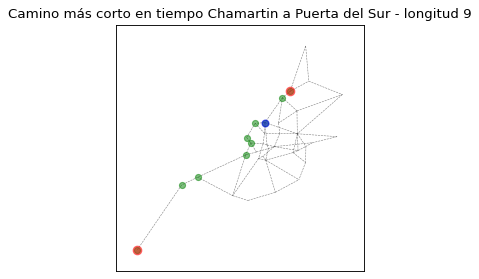

In [ ]:
#
# Mostramos la ruta más corta
#
#
# Mostramos la ruta más corta
#
draw_options_small = {"font_size": 0, "node_size": 50, "edgecolors": "grey", "linewidths": 0.2, "width": 1}
figure(figsize=(4, 4), dpi=80)
nx.draw_networkx_nodes(G,G.position, node_color='grey', alpha=0.5, node_size=0)
nx.draw_networkx_nodes(G,G.position, nodelist=path_complete, node_color='green', alpha=0.5, node_size=30)
nx.draw_networkx_nodes(G,G.position, nodelist=[start_stop, end_stop], node_color='red', alpha=0.5, node_size=60)
nx.draw_networkx_nodes(G,G.position, nodelist=[commuting_stop], node_color='blue', alpha=0.5, node_size=40)

nx.draw_networkx_edges(G,G.position, style='dashed',width = 0.5, alpha=0.5)
plt.title('Camino más corto en tiempo ' + start_stop + ' a '+end_stop +' - longitud ' + str(len(path_complete) - 1))
plt.show()